In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


##Import any other packages you may need here
import imageio

ModuleNotFoundError: No module named 'imageio'

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

In [275]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_xray_df.sample(3)

data_sample = pd.read_csv('sample_labels.csv')
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5203,00027765_000.png,Infiltration,0,27765,002Y,M,AP,2544,3056,0.139,0.139
1602,00008328_005.png,No Finding,5,8328,059Y,F,AP,2500,2048,0.171,0.171
19,00000116_013.png,Cardiomegaly|Consolidation,13,116,075Y,F,AP,2500,2048,0.168,0.168


Also, **describe your findings and how will you set up the model training based on the findings.**

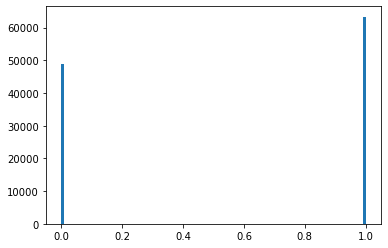

In [44]:
## EDA
xray = all_xray_df
xray["Patient Gender"] = np.where(xray["Patient Gender"] == "M",1,0)
plt.hist(xray["Patient Gender"],bins = 100);

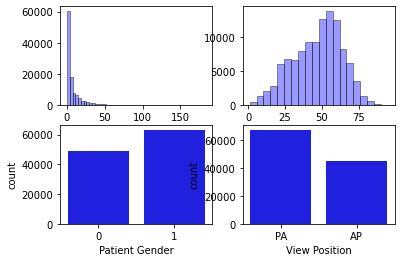

In [96]:
def distributions():
    col = ["Follow-up #", "Patient Age", "Patient Gender", "View Position"]
    plt.subplot(2,2,1)
    sns.distplot(xray[col[0]], hist=True, kde=False, bins=50, color = 'blue', hist_kws = {'edgecolor':'black'});
    plt.subplot(2,2,2)
    sns.distplot(xray[col[1]], hist=True, kde=False, bins=20, color = 'blue', hist_kws = {'edgecolor':'black'});
    plt.subplot(2,2,3)
    sns.countplot(xray[col[2]], color = 'blue');
    plt.subplot(2,2,4)
    sns.countplot(xray[col[3]], color = 'blue');
distributions()

In [60]:
#Looks like we have data that doesn't make sense. Follow-up # and Patient Age are two culprits. Let's take a look
xray[xray["Follow-up #"] == xray["Follow-up #"].max()]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
38264,00010007_183.png,Effusion|Infiltration,183,10007,59,1,AP,2500,2048,0.168,0.168,NaN


In [72]:
pd.set_option('display.max_rows', 10)
xray[xray["Patient ID"] == 10007]

# This patient seems to have shown every single disease in their 183 follow-ups! Let's assume this data is accurate.

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
38081,00010007_000.png,No Finding,0,10007,57,1,PA,2992,2991,0.143,0.143,NaN
38082,00010007_001.png,No Finding,1,10007,58,1,AP,2500,2048,0.168,0.168,NaN
38083,00010007_002.png,Infiltration,2,10007,58,1,AP,2500,2048,0.168,0.168,NaN
38084,00010007_003.png,Edema,3,10007,58,1,AP,2500,2048,0.168,0.168,NaN
38085,00010007_004.png,Edema|Effusion|Infiltration,4,10007,58,1,AP,2500,2048,0.168,0.168,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
38260,00010007_179.png,Atelectasis|Effusion,179,10007,59,1,AP,2500,2048,0.168,0.168,NaN
38261,00010007_180.png,Infiltration|Pleural_Thickening,180,10007,59,1,AP,2500,2048,0.168,0.168,NaN
38262,00010007_181.png,No Finding,181,10007,59,1,AP,2500,2048,0.168,0.168,NaN
38263,00010007_182.png,Consolidation,182,10007,59,1,AP,2500,2048,0.168,0.168,NaN


In [73]:
# Now let's look at Patient Age
xray["Patient Age"].max()

414

In [78]:
# Maximum age is 414? That does not make sense!
np.transpose(set(xray["Patient Age"].values))

array({1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 148, 149, 150, 151, 152, 153, 154, 155, 411, 412, 413, 414},
      dtype=object)

In [81]:
# Looks like every age after 95 is incorrect. We should drop this data.
xray = xray[xray["Patient Age"] <= 95]

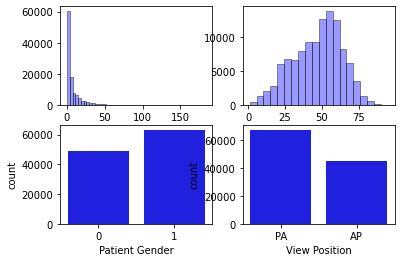

In [97]:
#Let's check the distributions again
distributions()

Looks like our patients are 50-60 years old.
There's slightly more men than women.
There are more PA views than AP
Most of the images are from their first visit.

In [256]:
# Now let's take a look at the findings.
# First to extract the data in the  "Finding Labels" column and one-hot-ecode.

diseases = ["Atelectasis", "Consolidation", "Infiltration", "Pneumothorax", "Edema", "Emphysema", "Fibrosis", "Effusion", "Pneumonia", "Pleural_Thickening", "Cardiomegaly", "Nodule", "Mass", "Hernia", "No Finding"]
for d in diseases:
    xray[d] = 0

for i, word in enumerate(xray["Finding Labels"]):
    split = word.split("|")
    for disease in split:
        xray[i:i+1][disease] = 1

In [257]:
# Now see how many pneumonia vs non-pneumonia cases we have.
print("Cases with Pneumonia: ", (xray["Finding Labels"] == "Pneumonia").sum())
print("Cases without Pneumonia: ", xray["Pneumonia"].count()-xray["Pneumonia"].sum())

Cases with Pneumonia:  322
Cases without Pneumonia:  110674


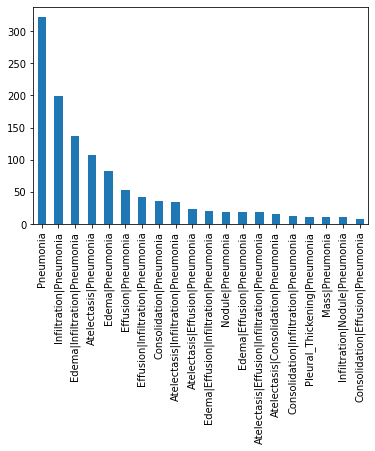

In [258]:
# Now lets look at how the diseases are distributed. Since we are focusing on Pneumonia, we'll focus those cases that have Pneumonia and also with cormobidity.
pneumonia = xray[xray["Finding Labels"].str.contains("Pneumonia")]["Finding Labels"]
pneumonia.value_counts()[:20].plot(kind="bar")

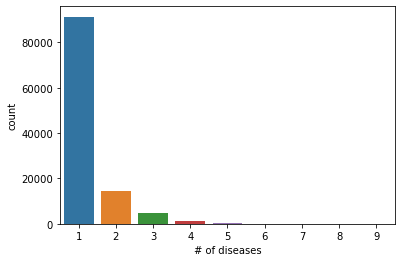

In [270]:
# Pneumonia with no co-morbodity has the highest prevalence compared to those with comorbidities.
# Now let's look at the number of diseases each patient has

xray["# of diseases"] = 0
xray["# of diseases"] = xray[xray.columns[12:]].sum(axis=1)
sns.countplot(xray["# of diseases"])

In [271]:
# Most people have only 1 detected disease.

# Now to check distribution of pixel data on a sample of images

In [277]:
data_sample["Image Index"]

0       00000013_005.png
1       00000013_026.png
2       00000017_001.png
3       00000030_001.png
4       00000032_001.png
              ...       
5601    00030712_000.png
5602    00030786_005.png
5603    00030789_000.png
5604    00030792_000.png
5605    00030797_000.png
Name: Image Index, Length: 5606, dtype: object

In [318]:
# get the path list for all images
paths_list = glob("**", recursive=True)

In [352]:
# only keep paths of images that are in the sample set
paths = [path for path in paths_list if any(p in path for p in data_sample["Image Index"])]

In [356]:
image = imageio.imread(paths[0])

NameError: name 'imageio' is not defined